In [16]:
import sys
sys.path.append("../../")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from example_lorenz import generate_lorenz_data, get_lorenz_data
import os
import pickle
from autoencoder import FullNetwork as FullNetwork
import torch
from training import prepare_data
from sindy_utils import sindy_simulate

data_path = os.getcwd() + '\\'
save_name = 'lorenz_2024_05_23_19_21_05_246526'
# save_name = 'model1'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name
# dataframe = pd.read_pickle('model1_params.pkl')
# print(dataframe)
# print(dataframe['coefficient_mask'])

def convert_to_cpu_numpy(obj):
    """
    Recursively convert torch.Tensor objects to numpy arrays,
    handling dictionaries and lists.
    
    Parameters:
    obj (any): The object to convert, which could be a tensor, list, or dictionary.

    Returns:
    any: The converted object with tensors replaced by numpy arrays.
    """
    if isinstance(obj, torch.Tensor):
        return obj.cpu().numpy()  #
    elif isinstance(obj, dict):
        #
        return {k: convert_to_cpu_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        # 
        return [convert_to_cpu_numpy(v) for v in obj]
    else:
        return obj  
# dataframe['coefficient_mask'] = dataframe['coefficient_mask'].apply(convert_to_cpu_numpy)
# dataframe['sindy_coefficients'] = dataframe['sindy_coefficients'].apply(convert_to_cpu_numpy)


# Xi_plot = np.array(dataframe['coefficient_mask']*dataframe['sindy_coefficients'])[0]
# sindy_coefficients = np.array(dataframe['sindy_coefficients'])[0]
# coefficient_mask = np.array(dataframe['coefficient_mask'])[0]
# print(dataframe['coefficient_mask'][0])
   

In [17]:
params['device'] = 'cuda:0'
autoencoder_network = FullNetwork(params).to(params['device'])
path = data_path + 'lorenz_2024_05_23_19_21_05_246526.pth'
state_dict = torch.load(path)
# print state_dict values
# for key in state_dict:
#     print(key)
#     print(state_dict[key])
autoencoder_network.load_state_dict(state_dict)

Xi_plot = np.array(state_dict['coefficient_mask']*state_dict['sindy_coefficients'])
print(Xi_plot)
sindy_coefficients = np.array(state_dict['sindy_coefficients'])
print(sindy_coefficients)
coefficient_mask = np.array(state_dict['coefficient_mask'])
print(coefficient_mask)

[[ 0.         -0.9742881   1.377123  ]
 [-9.886973    7.7502136  -0.3670626 ]
 [17.901659   -0.          4.5620646 ]
 [ 0.         -0.         -2.2022872 ]
 [-0.         -1.8181009  -0.        ]
 [ 0.6020893  -0.65418416 -7.4420953 ]
 [ 0.18556933 10.420333    0.        ]
 [-0.          0.         -0.        ]
 [ 0.         -0.         -0.86557233]
 [-0.          1.6047627   0.        ]
 [-0.          0.          0.        ]
 [-0.4748001  -0.2560544  -0.35700136]
 [-0.13331886  0.52386546 -0.        ]
 [ 0.         -0.          0.        ]
 [ 0.          0.          0.44762093]
 [ 0.         -0.53162897 -0.3214544 ]
 [ 0.          0.         -0.        ]
 [-0.         -0.          0.        ]
 [ 0.          0.          0.        ]
 [-0.         -0.19925214 -0.2470296 ]]
[[ 2.31999904e-04 -9.74288106e-01  1.37712300e+00]
 [-9.88697338e+00  7.75021362e+00 -3.67062598e-01]
 [ 1.79016590e+01 -1.71683991e-04  4.56206465e+00]
 [ 3.71270544e-05 -2.50665107e-05 -2.20228720e+00]
 [-9.50105969e-

In [18]:
t = np.arange(0,20,.01)
z0 = np.array([[-8,7,27]])

test_data = generate_lorenz_data(z0, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]))
test_data['x'] = torch.tensor(test_data['x'].reshape((-1,params['input_dim'])), dtype=torch.float32).to(params['device'])
test_data['dx'] = torch.tensor(test_data['dx'].reshape((-1,params['input_dim'])), dtype=torch.float32).to(params['device'])
test_data['z'] = test_data['z'].reshape((-1,params['latent_dim']))
test_data['dz'] = test_data['dz'].reshape((-1,params['latent_dim']))

In [19]:
a1 = 1
a2 = test_data['sindy_coefficients'][2, 0]/sindy_coefficients[2,0]
# a3 = np.sqrt(-sindy_coefficients[5,2]/sindy_coefficients[6,1]*a2**2)
a3 = np.sqrt(-sindy_coefficients[5,2]/sindy_coefficients[6,1]*a2**2)
print(a1,a2,a3)
b3 = -sindy_coefficients[0,2]/sindy_coefficients[3,2]

sindy_coefficients_transformed = np.zeros(sindy_coefficients.shape)
sindy_coefficients_transformed[1,0] = sindy_coefficients[1,0]
sindy_coefficients_transformed[2,0] = sindy_coefficients[2,0]*a2/a1
sindy_coefficients_transformed[1,1] = sindy_coefficients[6,1]*a1/a2*b3
sindy_coefficients_transformed[2,1] = sindy_coefficients[2,1]
sindy_coefficients_transformed[6,1] = sindy_coefficients[6,1]*a1*a3/a2
sindy_coefficients_transformed[3,2] = sindy_coefficients[3,2]
sindy_coefficients_transformed[5,2] = sindy_coefficients[5,2]*a1*a2/a3

1 0.55860746 0.47207776163097703


In [20]:
test_results_z = autoencoder_network.forward(test_data['x'], test_data['dx'])[0]
test_results_z = test_results_z.cpu().detach().numpy()

z0_transformed = np.array([test_results_z[0,0]/a1,
                           test_results_z[0,1]/a2,
                           (test_results_z[0,2] - b3)/a3])

In [21]:

z_sim = sindy_simulate(test_results_z[0], t, coefficient_mask*sindy_coefficients,
                       params['poly_order'], params['include_sine'])

z_sim_transformed = sindy_simulate(z0_transformed, t, sindy_coefficients_transformed,
                                      params['poly_order'], params['include_sine'])

lorenz_sim = sindy_simulate(test_data['z'][0], t, test_data['sindy_coefficients'],
                            params['poly_order'], params['include_sine'])


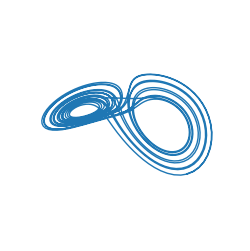

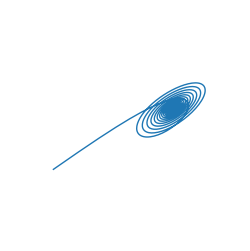

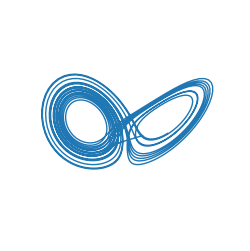

In [22]:
fig1 = plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(z_sim[:,0], z_sim[:,1], z_sim[:,2], linewidth=1)
plt.axis('off')
ax1.view_init(azim=120)
plt.show()


fig2 = plt.figure(figsize=(3,3))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(z_sim_transformed[:,0], z_sim_transformed[:,1], z_sim_transformed[:,2], linewidth=1)
plt.axis('off')
ax2.view_init(azim=120)
plt.show()


fig3 = plt.figure(figsize=(3,3))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot(lorenz_sim[:,0], lorenz_sim[:,1], lorenz_sim[:,2], linewidth=1)
plt.xticks([])
plt.axis('off')

ax3.view_init(azim=120)

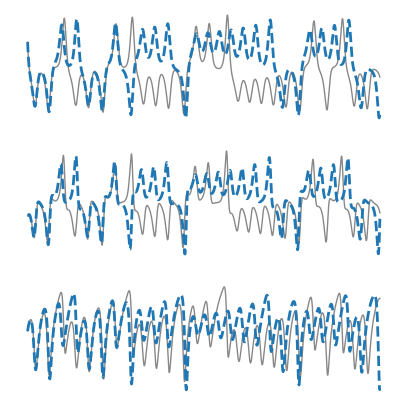

In [23]:
plt.figure(figsize=(5,5))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(t, test_results_z[:,i], color='#888888', linewidth=1)
    plt.plot(t, z_sim[:,i], '--', linewidth=2)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

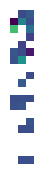

[[ 0.         -0.9742881   1.377123  ]
 [-9.886973    7.7502136  -0.3670626 ]
 [17.901659   -0.          4.5620646 ]
 [ 0.         -0.         -2.2022872 ]
 [-0.         -1.8181009  -0.        ]
 [ 0.6020893  -0.65418416 -7.4420953 ]
 [ 0.18556933 10.420333    0.        ]
 [-0.          0.         -0.        ]
 [ 0.         -0.         -0.86557233]
 [-0.          1.6047627   0.        ]
 [-0.          0.          0.        ]
 [-0.4748001  -0.2560544  -0.35700136]
 [-0.13331886  0.52386546 -0.        ]
 [ 0.         -0.          0.        ]
 [ 0.          0.          0.44762093]
 [ 0.         -0.53162897 -0.3214544 ]
 [ 0.          0.         -0.        ]
 [-0.         -0.          0.        ]
 [ 0.          0.          0.        ]
 [-0.         -0.19925214 -0.2470296 ]]


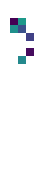

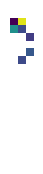

In [24]:

Xi_plot = np.where(Xi_plot == 0, np.inf, Xi_plot)
fig_sindy1 = plt.figure(figsize=(1,2))
plt.imshow(Xi_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])
plt.show()

print(coefficient_mask*sindy_coefficients)

Xi_transformed_plot = np.copy(sindy_coefficients_transformed)
Xi_transformed_plot[Xi_transformed_plot==0] = np.inf
fig_sindy2 = plt.figure(figsize=(1,2))
plt.imshow(Xi_transformed_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])
plt.show()


Xi_true_plot = np.copy(test_data['sindy_coefficients'])
Xi_true_plot[Xi_true_plot==0] = np.inf
Xi_true_plot[6,1] = -1.
Xi_true_plot[5,2] = 1.
plt.figure(figsize=(1,2))
plt.imshow(Xi_true_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])


In [25]:
test_data = get_lorenz_data(100, noise_strength=1e-6)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = autoencoder_network
model.load_state_dict(state_dict)
model.eval()  


test_dictionary = prepare_data(test_data,params,device)


test_dictionary_ = {}
for key in test_dictionary:
    if key == "x" or key =="dx":
        test_dictionary_[key] = torch.tensor(test_dictionary[key]).to(device)


with torch.no_grad():  
    torch_results = model(**test_dictionary_)

test_set_results = []
for i, output in enumerate(torch_results):
    test_set_results.append(output.cpu().detach().numpy())

# return z, x_decode, dz, dx_decode, sindy_predict,x, dx, self.sindy_coefficients

C:\Users\zhaox\AppData\Local\Temp\ipykernel_8172\4052146228.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dictionary_[key] = torch.tensor(test_dictionary[key]).to(device)


(250,)


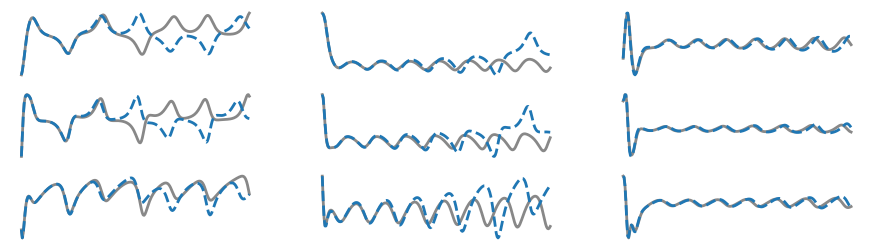

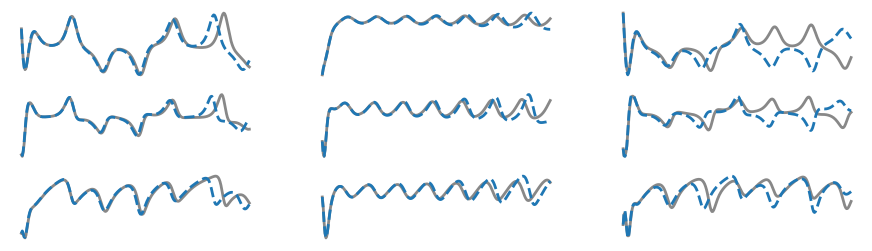

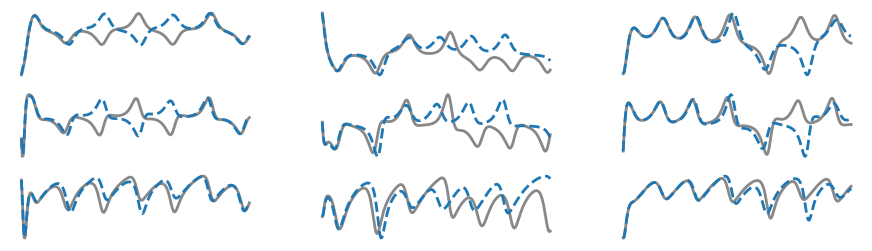

In [26]:
print(test_data['t'].shape)
for ic in range(9):
    idxs = np.arange(ic*250,(ic+1)*250)
    
    z_sim = sindy_simulate(test_set_results[0][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results[-1],
                           params['poly_order'], params['include_sine'])
    
    col_idx = ic % 3
    
    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results[0][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
#         plt.ylim(ylims[i])
        plt.axis('off')

Out of distribution

In [27]:
inDist_ic_widths = np.array([36,48,41])
outDist_extra_width = np.array([18,24,20])
full_width = inDist_ic_widths + outDist_extra_width

t = np.arange(0, 5, .02)
n_ics = 100

i = 0
ics = np.zeros((n_ics,3))
while i < n_ics:
    
    ic = np.array([np.random.uniform(-full_width[0],full_width[0]),
                   np.random.uniform(-full_width[1],full_width[1]),
                   np.random.uniform(-full_width[2],full_width[2]) + 25])
    if ((ic[0] > -inDist_ic_widths[0]) and (ic[0] < inDist_ic_widths[0])) \
        and ((ic[1] > -inDist_ic_widths[1]) and (ic[1] < inDist_ic_widths[1])) \
        and ((ic[2] > 25-inDist_ic_widths[2]) and (ic[2] < 25+inDist_ic_widths[2])):
        continue
    else:
        ics[i] = ic
        i += 1
        
noise_strength = 1e-6

# training test_data
test_data = generate_lorenz_data(ics, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]))
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['x'] += noise_strength*np.random.normal(size=test_data['x'].shape)
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['dx'] += noise_strength*np.random.normal(size=test_data['dx'].shape)

In [28]:
model = autoencoder_network
model.load_state_dict(state_dict)
model.eval()  


test_dictionary = prepare_data(test_data,params,device)


test_dictionary_ = {}
for key in test_dictionary:
    if key == "x" or key =="dx":
        test_dictionary_[key] = torch.tensor(test_dictionary[key]).to(device)


with torch.no_grad():  
    torch_results = model(**test_dictionary_)

test_set_results = []
for i, output in enumerate(torch_results):
    test_set_results.append(output.cpu().detach().numpy())

# return z, x_decode, dz, dx_decode, sindy_predict,x, dx, self.sindy_coefficients

C:\Users\zhaox\AppData\Local\Temp\ipykernel_8172\2528899748.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dictionary_[key] = torch.tensor(test_dictionary[key]).to(device)


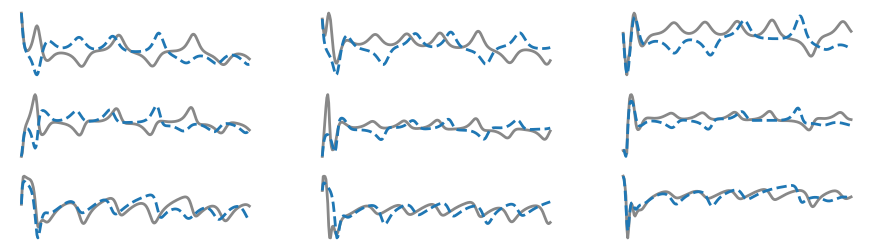

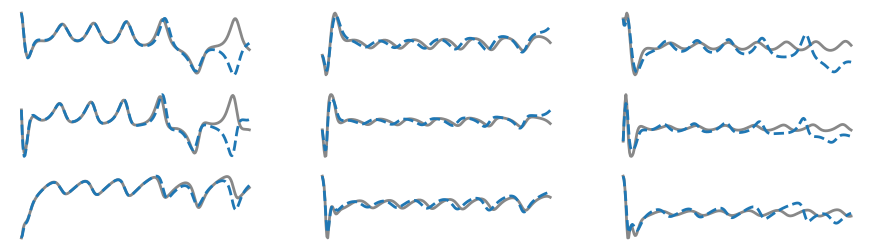

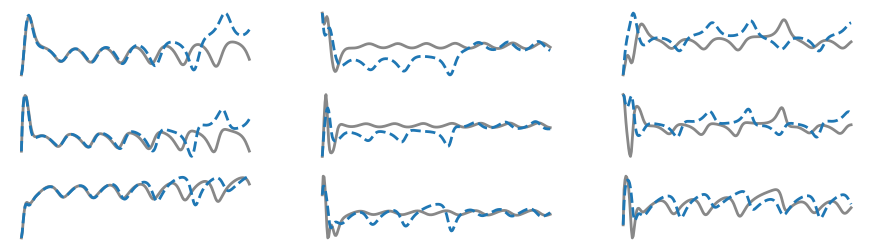

In [29]:
for ic in range(9):
    idxs = np.arange(ic*250,(ic+1)*250)
    
    z_sim = sindy_simulate(test_set_results[0][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results[-1],
                           params['poly_order'], params['include_sine'])
    
    col_idx = ic % 3
    
    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results[0][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
#         plt.ylim(ylims[i])
        plt.axis('off')